In [31]:
import numpy as np
import pandas as pd 
import os
import cv2
from sklearn.svm import SVC
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.color import rgb2gray
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from skimage.feature import hog
from skimage import data, exposure
import random
from keras import layers, losses
from keras.models import Model
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import math
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# Data 

In [32]:
#path server
#path = "/UTKFace/"
#path colab
#path = "/content/utkface_aligned_cropped/UTKFace"
#path martim
#path = "../../../../DadosProj/UTKFace/"
#path alex
path = "../../../data_project/UTKFace/"

files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
100_0_0_20170112213500903.jpg.chip.jpg


In [33]:
images = []
ages = []
genders = []
counter = 0

for file in files:
    if counter == 100:
        break

    image = cv2.imread(os.path.join(path, file))
    if image is not None and image.any():
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(200, 200))
        image = image.reshape((image.shape[0], image.shape[1], 3)) 
        image = image / 255.0

        images.append(image)
        delimit = file.split('_')
        ages.append(int(delimit[0]))
        genders.append(int(delimit[1]))

        counter += 1
        
X = np.squeeze(images)

In [34]:
### Age classes
age_classes = []
for i in ages:
    i = int(i)
    if i <= 1:
        age_classes.append(0)
    if (i>1) and (i<=13):
        age_classes.append(1)
    if (i>13) and (i<17):
        age_classes.append(2)
    if (i>=17) and (i<30):
        age_classes.append(3)
    if (i>=30) and (i<60):
        age_classes.append(4)
    if i>=60:
        age_classes.append(5)

age_labels = ["Baby",   # index 0
        "Infant",       # index 1
        "Adolescent",   # index 2 
        "Young Adult",  # index 3 
        "Adult"         # index 4
        "Old Adult",    # index 5
        ]

age_categories = to_categorical(age_classes, num_classes=6)
age_categories[:20]
print("Age Classes finished")

Age Classes finished


In [35]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')
age_classes = pd.Series(list(age_classes), name = 'Age_classes')


df_original = pd.concat([images, ages, age_classes, genders], axis=1)
df_original

,Images,Ages,Age_classes,Genders
0,"[[[0.8431372549019608, 0.807843137254902, 0.78...",100,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",0
1,"[[[0.4627450980392157, 0.47843137254901963, 0....",100,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",0
2,"[[[0.8588235294117647, 0.8745098039215686, 0.8...",100,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1
3,"[[[0.3058823529411765, 0.3215686274509804, 0.3...",100,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1
4,"[[[0.2549019607843137, 0.27058823529411763, 0....",100,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1
...,...,...,...,...
95,"[[[0.30980392156862746, 0.2627450980392157, 0....",10,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",0
96,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",10,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",0
97,"[[[0.9607843137254902, 0.9725490196078431, 0.9...",10,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",0
98,"[[[0.7176470588235294, 0.8431372549019608, 0.6...",10,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",0


## Data Distribution

### Ages

c:\Users\afbso\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ages', ylabel='Density'>

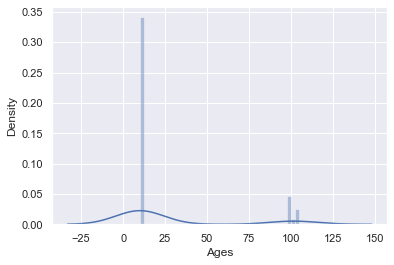

In [36]:
sns.set_theme()
sns.distplot(df_original['Ages'],kde=True, bins=40)

### Ages Classes

Text(0, 0.5, 'Counts')

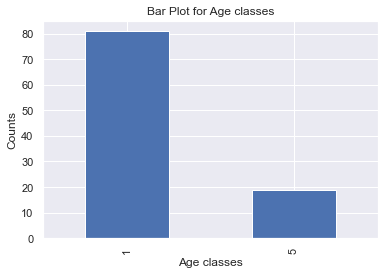

In [13]:
df_original["Age_classes"].value_counts().plot(kind='bar')

# set the title and axis labels
plt.title("Bar Plot for Age classes")
plt.xlabel("Age classes")
plt.ylabel("Counts")

In [14]:
print(df_original.Age_classes.value_counts())

1    81
5    19
Name: Age_classes, dtype: int64


### Balanced Age Classes

In [15]:
groups = df_original.groupby('Age_classes')

# create a list to hold the sampled dataframes
sampled_dfs = []

# randomly select 581 rows from each group
for name, group in groups:
    sampled_df = group.sample(580)
    sampled_dfs.append(sampled_df)

# concatenate the sampled dataframes into a single balanced dataframe
balanced_df_age_classes = pd.concat(sampled_dfs)

# reset the index of the new dataframe
balanced_df_age_classes = balanced_df_age_classes.reset_index(drop=True)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
balanced_df_age_classes["Age_classes"].value_counts().plot(kind='bar')

# set the title and axis labels
plt.title("Bar Plot for Balanced Age classes")
plt.xlabel("Balanced Age classes")
plt.ylabel("Counts")

In [ ]:
print(balanced_df_age_classes.Age_classes.value_counts())

## Gender

In [ ]:
df_original["Genders"].value_counts().plot(kind='bar')

# set the title and axis labels
plt.title("Bar Plot for Genders")
plt.xlabel("Genders")
plt.ylabel("Counts")

## Balanced Gender

In [ ]:
groups = df_original.groupby('Genders')

# create a list to hold the sampled dataframes
sampled_dfs = []

# randomly select 581 rows from each group
for name, group in groups:
    sampled_df = group.sample(10000)
    sampled_dfs.append(sampled_df)

# concatenate the sampled dataframes into a single balanced dataframe
balanced_df_gender = pd.concat(sampled_dfs)

# reset the index of the new dataframe
balanced_df_gender = balanced_df_gender.reset_index(drop=True)

In [ ]:
balanced_df_gender["Genders"].value_counts().plot(kind='bar')

# set the title and axis labels
plt.title("Bar Plot for Genders")
plt.xlabel("Genders")
plt.ylabel("Counts")

In [ ]:
print(balanced_df_gender.Genders.value_counts())

# New Datasets and variables

## Balanced Age Classes


In [ ]:
# Drop columns
balanced_df_age_classes = balanced_df_age_classes.drop(columns=['Ages', 'Genders'])

# shuffle the rows of the dataframe
balanced_df_age_classes = balanced_df_age_classes.sample(frac=1).reset_index(drop=True)

# reset the index of the shuffled dataframe
balanced_df_age_classes = balanced_df_age_classes.reset_index(drop=True)

# save the modified dataframe back to a csv file
#balanced_df_age_classes.to_csv("balanced_df_age_classes.csv", index=False)

## Balanced Gender

In [ ]:
# Drop columns
balanced_df_gender = balanced_df_gender.drop(columns=['Ages', 'Age_classes'])

# shuffle the rows of the dataframe
balanced_df_gender = balanced_df_gender.sample(frac=1).reset_index(drop=True)

# reset the index of the shuffled dataframe
balanced_df_gender = balanced_df_gender.reset_index(drop=True)

# save the modified dataframe back to a csv file
#balanced_df_gender.to_csv("balanced_df_gender.csv", index=False)

# New X's and y's

## Age Classes

In [ ]:
X_age_classes = []
y_age_classes = []

for i in range(len(balanced_df_age_classes)):
    ar = np.asarray(balanced_df_age_classes['Images'].iloc[i])
    X_age_classes.append(ar)
    agegen = int(balanced_df_age_classes['Age_classes'].iloc[i])
    y_age_classes.append(agegen)
X_age_classes = np.array(X_age_classes)

print(X_age_classes.shape)
print(len(y_age_classes))

In [ ]:
#np.savez('age_classes_vars.npz', x=X_age_classes, y=y_age_classes)

## Gender

In [ ]:
X_genders = []
y_genders = []

for i in range(len(balanced_df_gender)):
    ar = np.asarray(balanced_df_gender['Images'].iloc[i])
    X_genders.append(ar)
    agegen = int(balanced_df_gender['Genders'].iloc[i])
    y_genders.append(agegen)
X_genders = np.array(X_genders)

print(X_genders.shape)
print(len(y_genders))

In [ ]:
#np.savez('gender_vars.npz', x=X_genders, y=y_genders)